In [68]:
import numpy as np
import pandas as pd
import pymysql
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sqlalchemy
import pmdarima as pm
from pmdarima.model_selection import train_test_split
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [69]:
user = os.environ.get('DB_USER')
password = os.environ.get('DB_PWD')

In [70]:
connection = pymysql.connect(host='caskeycoding.com', user = user, passwd = password, port = 3306, db = 'caskey5_buffaloCrime')

In [71]:
connection

In [72]:
df = pd.read_sql_query('SELECT incident_date, police_district FROM full_incidents',connection)

In [73]:
df.head()

,incident_date,police_district
0,1910-12-22,District E
1,1914-12-01,District D
2,1951-07-03,District D
3,1951-12-05,District D
4,1952-08-30,District D


In [74]:
df = pd.DataFrame({'no_of_incidents' : df.groupby( [ df.police_district, df.incident_date.dt.date] ).size()}).reset_index()

In [75]:
df

,police_district,incident_date,no_of_incidents
0,,1981-06-20,1
1,,1986-07-02,1
2,,2000-06-21,1
3,,2002-06-02,1
4,,2002-10-05,1
...,...,...,...
30659,District E,2021-02-15,3
30660,District E,2021-02-16,3
30661,District E,2021-02-17,4
30662,District E,2021-02-18,2


In [76]:
 df.police_district.unique()

array(['', 'District A', 'District B', 'District C', 'District D',
       'District E'], dtype=object)

In [77]:
data_A = df[df['police_district'] == 'District A']
data_B = df[df['police_district'] == 'District B']
data_C = df[df['police_district'] == 'District C']
data_D = df[df['police_district'] == 'District D']
data_E = df[df['police_district'] == 'District E']

In [78]:
data_A

,police_district,incident_date,no_of_incidents
3228,District A,1900-01-01,1
3229,District A,1972-09-16,1
3230,District A,1981-07-14,1
3231,District A,1989-01-01,1
3232,District A,1990-08-25,1
...,...,...,...
8643,District A,2021-02-14,4
8644,District A,2021-02-15,3
8645,District A,2021-02-16,3
8646,District A,2021-02-17,4


In [79]:
arr = [data_A, data_B, data_C, data_D, data_E]

In [80]:
train = [None] * 5
test = [None] * 5

## Preprocessing the data

In [81]:
for i in range(5):
    arr[i] = arr[i].loc[:,['incident_date', 'no_of_incidents']]
    arr[i].set_index('incident_date', inplace = True)
    arr[i] = arr[i].asfreq('D')
    arr[i].no_of_incidents= arr[i].no_of_incidents.fillna(0.0)
    arr[i] = arr[i][arr[i].index >= '2009-01-01']
    arr[i] = arr[i].resample('W-SUN').sum()
    train[i]=arr[i][arr[i].index < arr[i].index[-4]]
    test[i]=arr[i][arr[i].index >= arr[i].index[-4]]

In [82]:
train[0].shape

(630, 1)

In [83]:
test[0].shape

(4, 1)

In [84]:
index_val = pd.date_range(train[0].index[-1], freq = 'W', periods = 4)
index_val

DatetimeIndex(['2021-01-24', '2021-01-31', '2021-02-07', '2021-02-14'], dtype='datetime64[ns]', freq='W-SUN')

In [85]:
arima_models_val = [None] * 5
arima_forecasts_val = [None] * 5

## Applying and validating ARIMA

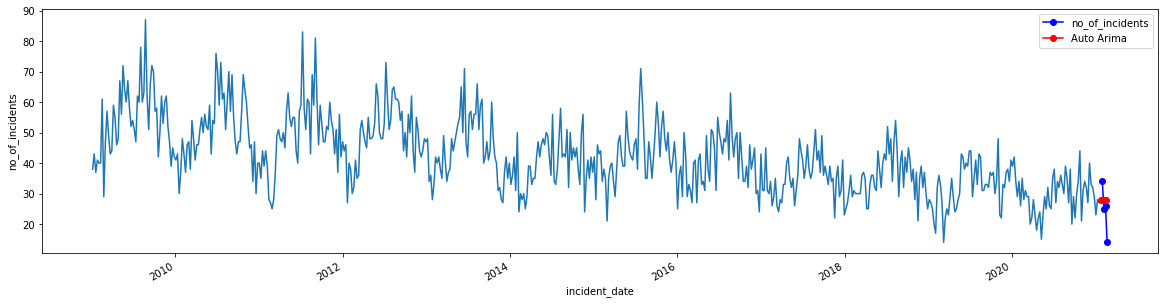

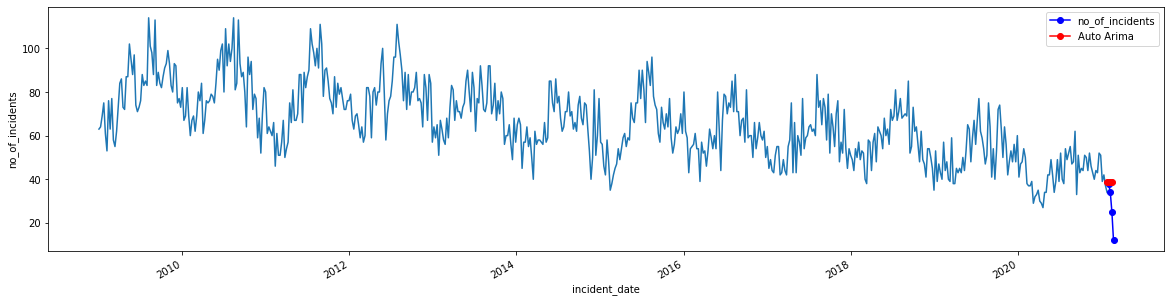

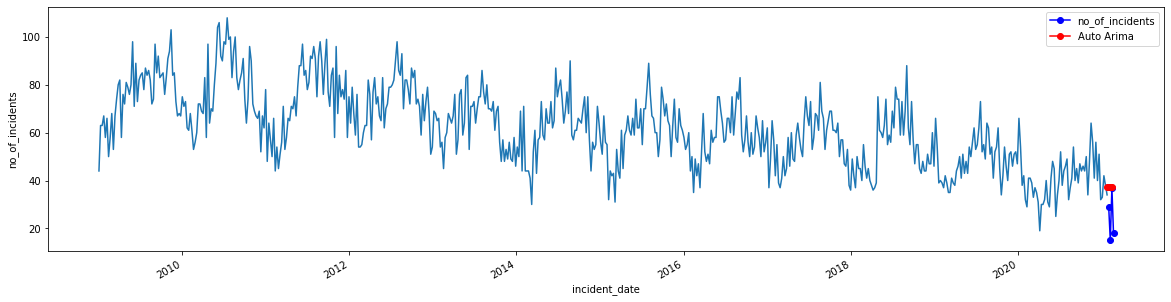

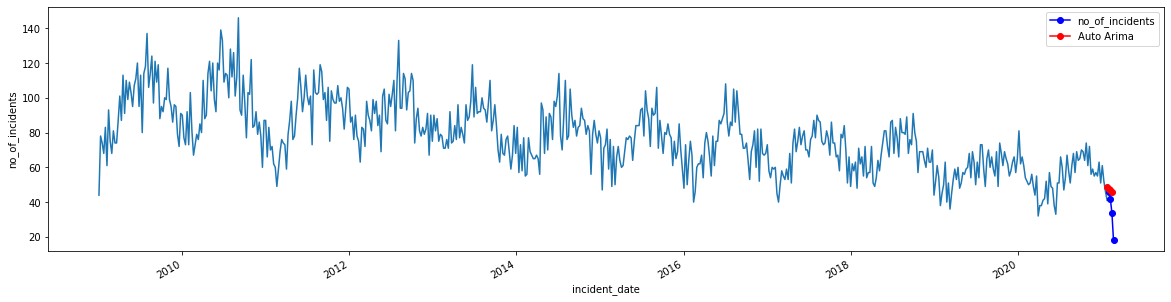

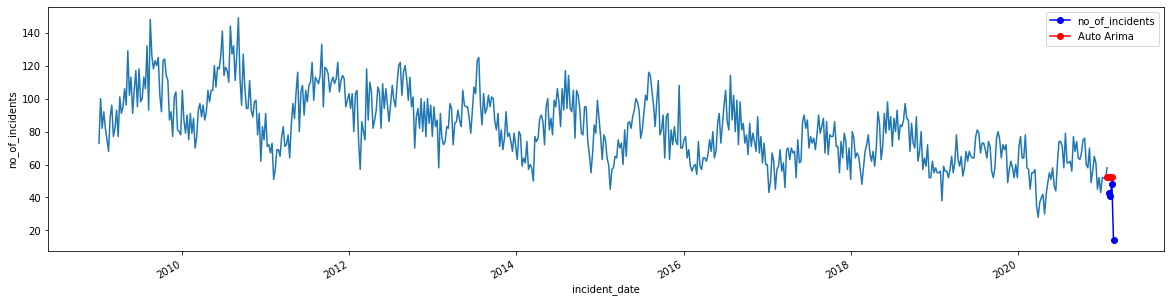

In [86]:
for i in range(5):
    arima_models_val[i] = pm.auto_arima(train[i], seasonal = False, m=0)
    arima_forecasts_val[i] = arima_models_val[i].predict(4)
    arima_forecasts_val[i] = pd.Series(arima_forecasts_val[i], index = index_val)
    arima_forecasts_val[i] = arima_forecasts_val[i].rename("Auto Arima")
    fig, ax = plt.subplots(figsize = (20,5))
    chart = sns.lineplot(x='incident_date', y='no_of_incidents', data=train[i])
    test[i].plot(ax=ax, color='blue', marker='o', legend=True)
    arima_forecasts_val[i].plot(ax=ax, color='red', marker='o', legend=True)

In [87]:
arima_rmse = [None] * 5
arima_mae = [None] * 5

In [88]:
for i in range(5):
    arima_rmse[i] = np.sqrt(mean_squared_error(test[i]['no_of_incidents'].values, arima_forecasts_val[i].values))
    arima_mae[i] = mean_absolute_error(test[i]['no_of_incidents'].values, arima_forecasts_val[i].values)

In [89]:
print('RMSE')
print(arima_rmse)
print('MAE')
print(arima_mae)

RMSE
[7.858697497387193, 15.123483292768332, 15.319898965804429, 15.730531463750111, 20.7120529632261]
MAE
[6.291265462408242, 11.394410789886386, 12.550370684663285, 12.29259262105403, 15.871258853870804]


## Prediction for the next 4 weeks

In [90]:
index = pd.date_range(test[0].index[-1], freq = 'W', periods = 4)
index

DatetimeIndex(['2021-02-21', '2021-02-28', '2021-03-07', '2021-03-14'], dtype='datetime64[ns]', freq='W-SUN')

In [91]:
arima_models= [None] * 5
arima_forecasts= [None] * 5

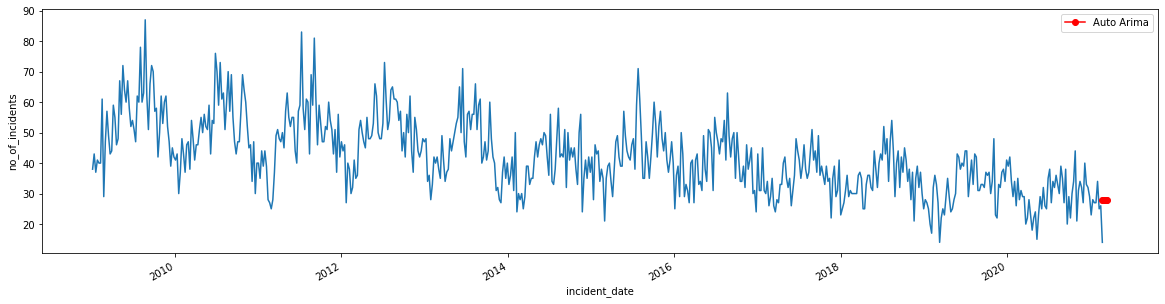

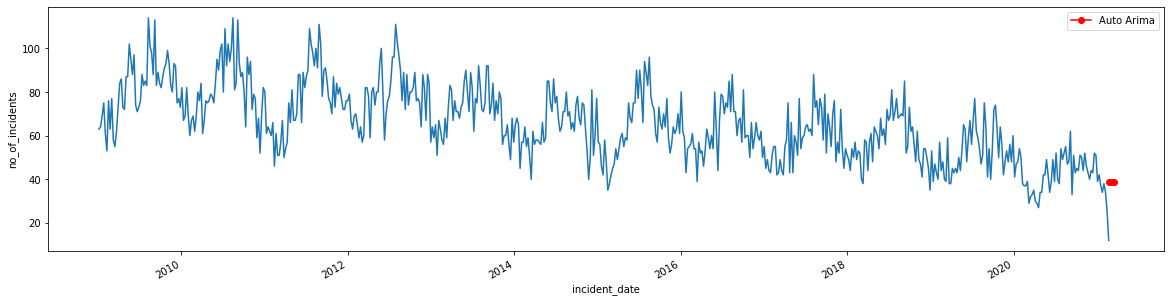

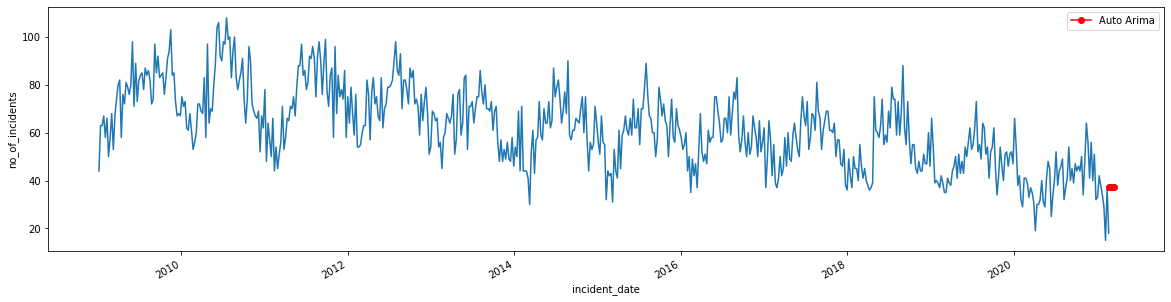

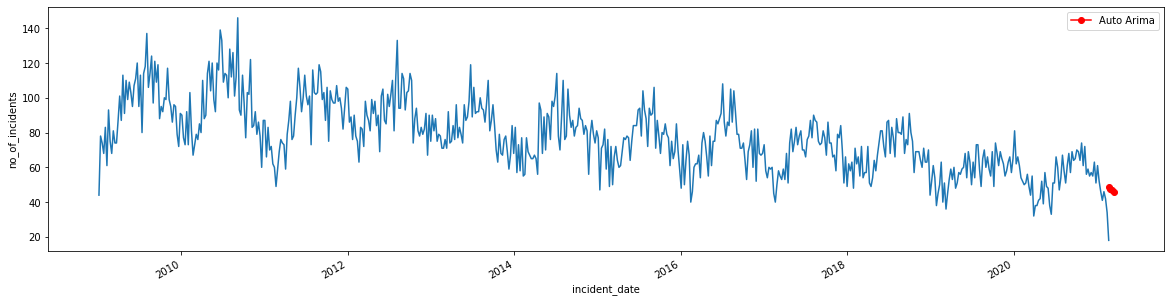

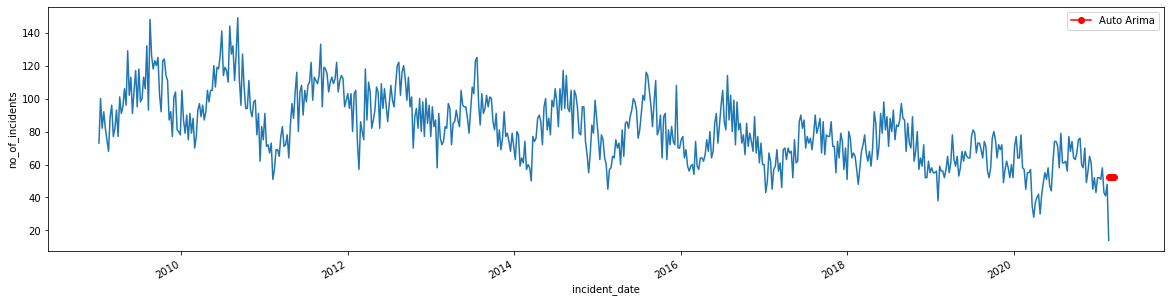

In [92]:
for i in range(5):
    arima_models[i] = pm.auto_arima(train[i], seasonal = False, m=0)
    arima_forecasts[i] = arima_models[i].predict(4)
    arima_forecasts[i] = pd.Series(arima_forecasts[i], index = index)
    arima_forecasts[i] = arima_forecasts[i].rename("Auto Arima")
    fig, ax = plt.subplots(figsize = (20,5))
    chart = sns.lineplot(x='incident_date', y='no_of_incidents', data=arr[i])
    arima_forecasts[i].plot(ax=ax, color='red', marker='o', legend=True)